# Loading the Dataset

In this section, we will load the **training** dataset from Hugging Face. Given the dataset contains approximately 40,000 samples, we will reduce this to 500 samples per class due to memory constraints on my personal machine, however this reduction will be done in several steps to make sure we have a diverse dataset. The process involves several steps:

## Stratified Sampling:

We will first select a total of 12,000 samples from the dataset, comprising 6,000 samples from each class.

## Sentiment-Based Sampling:

Upon reviewing the data samples, it is evident that some samples are ambiguous regarding their sentiment and could be labeled as positive, negative, or neutral. Additionally, some samples may have been incorrectly labeled.
To address this, we will perform sentiment analysis using the TextBlob model on the 6,000 selected samples. We will then select only those rows where both the model's predictions and the original labels agree. From these, we will randomly select 2000 samples per class to further refine our dataset.

## Semantic Similarity-Based Sampling:

To enhance diversity, we will compute semantic similarity using the Sentence-BERT model for all possible pairs of reviews within each class. Finally, we will select 500 least similar samples per class to ensure a broad representation of examples, amounting to 1000 samples in total.


**Note:**

I acknowledge that selecting a small sample size may affect the accuracy of the model. However, to meet the constraints mentioned above, I aimed to choose the most diverse examples.

In Step 2, it would be beneficial to run at least one more similarity model and compute inter-annotator agreement. This approach treats the models as additional annotators alongside the original labels, ensuring we choose the most accurate labels for a better understanding of the LLM's performance.

You might consider the following options for additional models, though I have avoided using them for this task to minimize unnecessary overhead:

1. FastText: Developed by Facebook, FastText allows for quick text classification. You can train a FastText model on your sentiment data and use it for predictions.

2. VADER Sentiment Analysis: Specifically tuned for analyzing sentiment in social media text, VADER works quickly with a straightforward lexicon and can be effective for movie reviews.

3. Smaller Transformer Models: Consider using models like ALBERT or RoBERTa, which have been optimized for speed and may perform faster than BERT. Several fine-tuned BERT-based models for sentiment analysis are available on Hugging Face.

In [3]:
# Loading the saved data. the code for creating this sampling is available in data_loader.py
import os
import pandas as pd
from config import SAMPLED_DATA_PATH

sampled_dataset = pd.read_csv(SAMPLED_DATA_PATH, sep='\t')
print(sampled_dataset.head(3))

                                              review     label  \
0  I saw this film on TV many years ago and I saw...  positive   
1  If you had asked me how the movie was througho...  positive   
2  Another one of those films you hear about from...  positive   

  textblob_predicted_label  
0                 positive  
1                 positive  
2                 positive  


## Basic Data Analysis

**Note**

Normally class '0' is associated with negative label and class '1' is associated with positive label. However, in this dataset, this was not the case. To avoid model bias in prediction, we mapped the 0 and 1 to their corresponding classes in this dataset, namely positive and negative respectively. 

### Lexical Diversity:
 I measure the range of unique words (vocabulary richness) in each class. This could help identify differences in how the positive and negative reviews are expressed, which might affect the LLM's ability to generalize across different sentiment tones.

### Sentiment Word Count: 
I analyze the frequency of sentiment-specific words in each class. For instance, words like "love," "amazing," "horrible," or "terrible" might appear more frequently in one class. This can indicate whether the LLM is biased towards recognizing certain sentiment words.

### Polarity and Subjectivity: 
I use TextBlob to analyze polarity (positive/negative sentiment) and subjectivity (degree of opinion). This can serve as a comparison baseline for the LLM’s predictions.

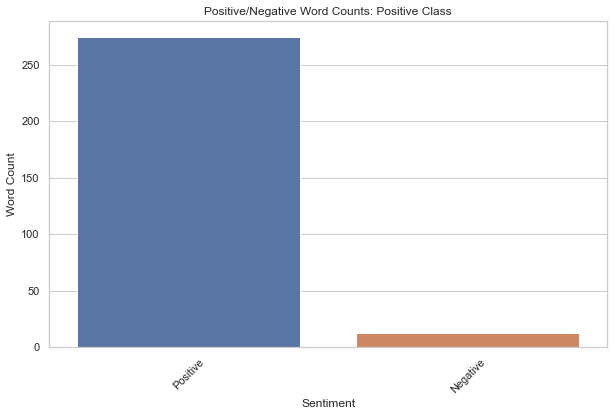

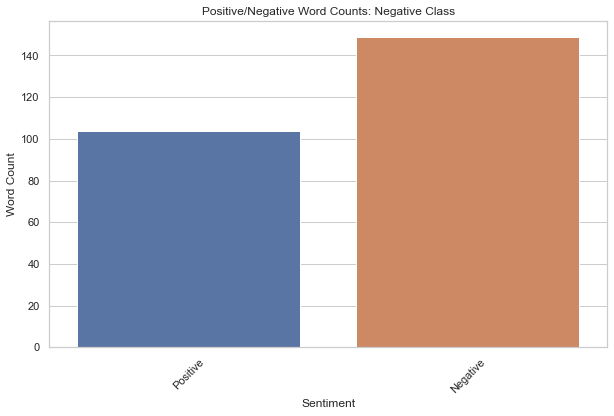

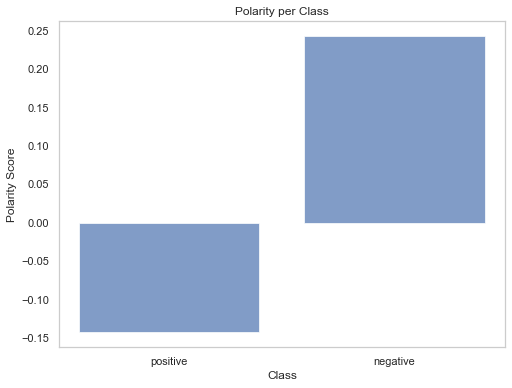

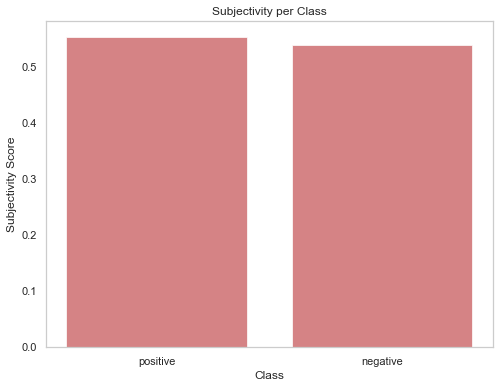

Class positive Sentence Length Analysis:
Average Sentence Length: 152.07 words
Longest Sentence Length: 1003 words
Shortest Sentence Length: 12 words
Class negative Sentence Length Analysis:
Average Sentence Length: 127.92 words
Longest Sentence Length: 915 words
Shortest Sentence Length: 10 words


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from textblob import TextBlob
import numpy as np

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Visual settings
sns.set(style="whitegrid")

# Define sentiment-specific words from the paper at https://aclanthology.org/P11-1015/
positive_words = [
    'melancholy', 'bittersweet', 'thoughtful', 'poetic', 'heartbreaking', 'warmth', 'lyrical', 
    'happiness', 'layer', 'poetry', 'tenderness', 'gentle', 'profound', 'compassionate', 
    'loneliness', 'vivid', 'romantic', 'romance', 'love', 'charming', 'screwball', 'sweet', 
    'delightful', 'grant', 'beautiful', 'comedies', 'relationship', 'chemistry', 'comedy'
]

negative_words = [
    'ghastly', 'embarrassingly', 'predators', 'hideous', 'trite', 'inept', 'laughably', 'tube', 
    'severely', 'atrocious', 'baffled', 'grotesque', 'appalling', 'smack', 'unsuspecting', 
    'lackluster', 'lame', 'passable', 'uninspired', 'laughable', 'unconvincing', 'flat', 
    'unimaginative', 'amateurish', 'bland', 'clichéd', 'forgettable', 'awful', 'insipid', 'mediocre'
]

def plot_distribution(title, data, xlabel, ylabel):
    """Helper function to create a Seaborn bar plot"""
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(data.keys()), y=list(data.values()))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

# 1. plot positive and negative word count for each class using SpaCy
def analyze_positive_negative_word_count(reviews):
    """Count occurrences of predefined positive and negative words in reviews"""
    
    # Convert the word lists to sets for efficient lookups
    positive_word_set = set(positive_words)
    negative_word_set = set(negative_words)
    
    positive_count, negative_count = 0, 0
    
    for review in reviews:
        # Tokenize the review using SpaCy
        doc = nlp(review.lower())
        
        # Filter tokens to keep only words (exclude punctuation, spaces, etc.)
        tokens = [token.text for token in doc if token.is_alpha]
        
        # Count positive and negative words
        positive_count += sum(1 for word in tokens if word in positive_word_set)
        negative_count += sum(1 for word in tokens if word in negative_word_set)
    
    return positive_count, negative_count

# 2. Polarity and Subjectivity (Using TextBlob)
def analyze_polarity_subjectivity(texts):
    polarity, subjectivity = [], []
    for text in texts:
        blob = TextBlob(text)
        polarity.append(blob.sentiment.polarity)
        subjectivity.append(blob.sentiment.subjectivity)
    return np.mean(polarity), np.mean(subjectivity)

# Separate plots for polarity and subjectivity
def plot_polarity_subjectivity(df, class_column='label', text_column='review'):
    polarity_subjectivity = df.groupby(class_column)[text_column].apply(lambda texts: analyze_polarity_subjectivity(texts))
    polarity = [p[0] for p in polarity_subjectivity]
    subjectivity = [p[1] for p in polarity_subjectivity]
    
    classes = df[class_column].unique()
    
    # Polarity Plot
    plt.figure(figsize=(8, 6))
    plt.bar(classes, polarity, alpha=0.7, color='b', label='Polarity')
    plt.title('Polarity per Class')
    plt.xlabel('Class')
    plt.ylabel('Polarity Score')
    plt.xticks(classes)
    plt.grid(False)  # Remove horizontal grid
    plt.show()

    # Subjectivity Plot
    plt.figure(figsize=(8, 6))
    plt.bar(classes, subjectivity, alpha=0.7, color='r', label='Subjectivity')
    plt.title('Subjectivity per Class')
    plt.xlabel('Class')
    plt.ylabel('Subjectivity Score')
    plt.xticks(classes)
    plt.grid(False)  # Remove horizontal grid
    plt.show()

# 3. Sentence Length Analysis
def analyze_sentence_lengths(reviews):
    """Calculate average, longest, and shortest sentence length based on whitespace tokenization."""
    sentence_lengths = [len(review.split()) for review in reviews]
    
    average_length = np.mean(sentence_lengths)
    longest_sentence = max(sentence_lengths)
    shortest_sentence = min(sentence_lengths)
    
    print(f"Average Sentence Length: {average_length:.2f} words")
    print(f"Longest Sentence Length: {longest_sentence} words")
    print(f"Shortest Sentence Length: {shortest_sentence} words")
    
# Analyzing the dataset
def analyze_dataset(df):
    # Separate classes
    class_0_reviews = df[df['label'] == 'positive']['review'].tolist()
    class_1_reviews = df[df['label'] == 'negative']['review'].tolist()

    # 2. Positive and Negative Word Count
    class_0_positive_count, class_0_negative_count = analyze_positive_negative_word_count(class_0_reviews)
    class_1_positive_count, class_1_negative_count = analyze_positive_negative_word_count(class_1_reviews)

    # Visualization of positive and negative word counts
    plot_distribution(
        "Positive/Negative Word Counts: Positive Class", 
        {'Positive': class_0_positive_count, 'Negative': class_0_negative_count}, 
        "Sentiment", "Word Count"
    )
    plot_distribution(
        "Positive/Negative Word Counts: Negative Class", 
        {'Positive': class_1_positive_count, 'Negative': class_1_negative_count}, 
        "Sentiment", "Word Count"
    )
    
    # Polarity and Subjectivity
    plot_polarity_subjectivity(df)

    # Sentence Length Analysis
    print("Class positive Sentence Length Analysis:")
    analyze_sentence_lengths(class_0_reviews)
    
    print("Class negative Sentence Length Analysis:")
    analyze_sentence_lengths(class_1_reviews)


analyze_dataset(sampled_dataset)


## Interpretation:

1. As can be seen from the visualizations,there is a mixed presence of positive words in the negative class which hints at polarity ambiguity. This could potentially bias the model to predict more 'positive' labels instead of 'negative' labels for the negative class. The poliarity ambiguity between classes can also be observed in sensitivity plot in favor of the positive class.

2. The presence of very long sentences in both classes suggests that reviews might contain extensive descriptions, possibly providing nuanced opinions or storytelling elements. The shorter sentences could indicate succinct expressions of sentiment, particularly in negative reviews, where a clear negative statement might be communicated quickly. However, there is no significant difference between sentence length in both classes.

## Langchain Recusrive Chunking

The model has a context window of 512 tokens, which is insufficient to input all the data at once, given the length of the sentences in our dataset. To address this, we will employ the 'recursive chunking' technique from Langchain. This method involves breaking the text into chunks with overlapping words, ensuring that surrounding context is included in each review input. While this approach may introduce some redundancy, it will enhance label predictions for the movie reviews.

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import pandas as pd

# Create the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

# Function to split reviews using LangChain's text splitter
def split_reviews_with_langchain(reviews):
    split_reviews = []
    for index, row in reviews.iterrows():
        review = row['review']
        label = row['label']

        # Create chunks using LangChain's text splitter
        chunks = text_splitter.create_documents([review])

        # Append each chunk along with the original label to the list
        for chunk in chunks:
            split_reviews.append({'label': label, 'review': chunk.page_content, 'original_index': index})

    return pd.DataFrame(split_reviews)

df_split = split_reviews_with_langchain(sampled_dataset)

## Model Prediction Postprocessing

The models may not always adhere to the output format specified in the prompt. The code below will take care of post-processing the labels predicted by the model.

In [ ]:
import re

# Function to clean the labels after model prediction
def clean_label(label):
    # Convert to lowercase and strip whitespace
    label = str(label).strip().lower()
    
    # Remove any unwanted characters (punctuation, <, >)
    label = re.sub(r'[<>!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', label)
    
    # Map to 'positive' or 'negative', or return None for invalid
    if label in ['positive', 'positive.']:
        return 'positive'
    elif label in ['negative', 'negative.']:
        return 'negative'
    else:
        return None  # or 'unknown' to include it

# Models

Next, we will load the models for analysis.

In [ ]:
# See the parameters for different backends (CUDA, Vulkan, CPU) here:
# https://github.com/abetlen/llama-cpp-python?tab=readme-ov-file#supported-backends
!CMAKE_ARGS="-DGGML_BLAS=ON -DGGML_BLAS_VENDOR=OpenBLAS" pip install llama-cpp-python --no-cache-dir

In [ ]:
# Qwen 2.5, 0.5 Billion parameter model

from llama_cpp import Llama

llm_qwen_0_5 = Llama.from_pretrained(
    repo_id="bartowski/Qwen2.5-0.5B-Instruct-GGUF",
    # See the all quantization levels here:
    # https://huggingface.co/bartowski/Qwen2.5-0.5B-Instruct-GGUF/
    # It's better to start with *Q5_K_M, and if the results are too poor, continue with Q6_K or Q8_0.
    filename="*Q5_K_M.gguf",
    verbose=False
)

In [ ]:
# Qwen 2.5, 1.5 Billion parameter model

llm_qwen_1_5 = Llama.from_pretrained(
    repo_id="bartowski/Qwen2.5-1.5B-Instruct-GGUF",
    # See the all quantization levels here:
    # https://huggingface.co/bartowski/Qwen2.5-0.5B-Instruct-GGUF/
    # It's better to start with *Q5_K_M, and if the results are too poor, continue with Q6_K or Q8_0.
    filename="*Q5_K_M.gguf",
    verbose=False
)

## Classification Report Code

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

def generate_classification_metrics(df, label_col, prediction_prefix='predicted_output_temp_', num_temperatures=3, num_runs=3):
    # Initialize a list to store metrics for each predicted output
    metrics_summary = []

    # Loop through each temperature and run case
    for temp in range(num_temperatures):  # Temperature cases
        for run in range(1, num_runs + 1):  # Run cases
            col_name_pattern = f'{prediction_prefix}{temp}_run_{run}'
            
            # Find the actual column that contains this pattern
            matching_columns = [col for col in df.columns if col.startswith(col_name_pattern)]

            if len(matching_columns) == 0:
                print(f"No column found for pattern: {col_name_pattern}")
                continue  # Skip if no matching column found
            
            # Assume only one column matches (if there are multiple, you may need to handle it differently)
            col_name = matching_columns[0]

            # Remove rows where the predicted value is neither 'positive' nor 'negative'
            df_filtered = df[df[col_name].isin(['positive', 'negative'])]

            # Calculate classification report
            report = classification_report(df[label_col], df[col_name],
                                           target_names=['negative', 'positive'],
                                           output_dict=True)
            report_df = pd.DataFrame(report).T.drop(columns='support')

            # Calculate accuracy
            accuracy = accuracy_score(df[label_col], df[col_name])

            # Store the metrics for this run
            metrics_summary.append({
                'Temperature': temp,
                'Run': run,
                'Precision (Negative)': report['negative']['precision'],
                'Recall (Negative)': report['negative']['recall'],
                'F1 (Negative)': report['negative']['f1-score'],
                'Precision (Positive)': report['positive']['precision'],
                'Recall (Positive)': report['positive']['recall'],
                'F1 (Positive)': report['positive']['f1-score'],
                'Accuracy': accuracy
            })

            # Display the classification report and accuracy for this run
            print(f"Temperature {temp}, Run {run}:")
            print(f"  Classification Report for Qwen 2.5 - 0.5 B:")
            print(report_df)
            print(f"  Accuracy: {accuracy:.4f}")
            print("-" * 30)

    # Create a DataFrame to summarize all metrics
    metrics_df = pd.DataFrame(metrics_summary)

    # Calculate and report the average metrics for each temperature across the runs
    for temp in range(num_temperatures):
        temp_metrics = metrics_df[metrics_df['Temperature'] == temp]

        avg_metrics = {
            'Temperature': temp,
            'Precision (Negative)': temp_metrics['Precision (Negative)'].mean(),
            'Recall (Negative)': temp_metrics['Recall (Negative)'].mean(),
            'F1 (Negative)': temp_metrics['F1 (Negative)'].mean(),
            'Precision (Positive)': temp_metrics['Precision (Positive)'].mean(),
            'Recall (Positive)': temp_metrics['Recall (Positive)'].mean(),
            'F1 (Positive)': temp_metrics['F1 (Positive)'].mean(),
            'Average Accuracy': temp_metrics['Accuracy'].mean()
        }

        # Display the average metrics for the temperature across the runs
        print(f"Average metrics for Temperature {temp}:")
        print(f"  Precision (Negative): {avg_metrics['Precision (Negative)']:.4f}")
        print(f"  Recall (Negative): {avg_metrics['Recall (Negative)']:.4f}")
        print(f"  F1 (Negative): {avg_metrics['F1 (Negative)']:.4f}")
        print(f"  Precision (Positive): {avg_metrics['Precision (Positive)']:.4f}")
        print(f"  Recall (Positive): {avg_metrics['Recall (Positive)']:.4f}")
        print(f"  F1 (Positive): {avg_metrics['F1 (Positive)']:.4f}")
        print(f"  Average Accuracy: {avg_metrics['Average Accuracy']:.4f}")
        print("=" * 50)

    return metrics_df


## Analysis with Majority Voting

Since we created chunks of the original 'review' column, it is possible that the part of the review is positive but the overall sentiment is negative and vice versa. To account for that, we aggregate the results and perform a majority vote to compare against the true labels in the dataset.

In [ ]:
from collections import Counter

def majority_vote_predictions(df, original_index_col, label_col, prediction_prefix='predicted_output_temp_', num_temperatures=3, num_runs=3):

    # Group by 'original_index' to gather all predictions per original review
    def majority_vote_group(group):
        # Dynamically find all columns that start with the prediction prefix, temperature, and run
        prediction_columns = [col for col in df.columns if any(
            f'{prediction_prefix}{temp}_run_{run}' in col for temp in range(num_temperatures) for run in range(1, num_runs + 1)
        )]

        # Collect all predictions across the specified columns
        predictions = group[prediction_columns].values.flatten()

        # Filter out any predictions that are not 'positive' or 'negative'
        valid_predictions = [pred for pred in predictions if pred in ['positive', 'negative']]

        # Apply majority voting across the valid predictions
        if valid_predictions:
            return Counter(valid_predictions).most_common(1)[0][0]
        else:
            return None  # Return None if no valid predictions remain

    # Apply majority voting for each group of rows with the same 'original_index'
    majority_vote_results = df.groupby(original_index_col).apply(majority_vote_group).reset_index()
    majority_vote_results.columns = [original_index_col, 'majority_vote']

    # Remove rows where majority vote result is None
    majority_vote_results = majority_vote_results[majority_vote_results['majority_vote'].notnull()]

    # Merge the majority vote results back with the original labels
    df_final = df[[original_index_col, label_col]].drop_duplicates().merge(majority_vote_results, on=original_index_col)

    # Calculate classification report for majority-vote predictions
    report = classification_report(df_final[label_col], df_final['majority_vote'], target_names=['negative', 'positive'], output_dict=True)
    report_df = pd.DataFrame(report).T.drop(columns='support')
    accuracy = accuracy_score(df_final[label_col], df_final['majority_vote'])

    # Display the classification report and accuracy
    print(f"Classification Report for majority voting:")
    print(report_df)
    print(f"Accuracy for majority voting: {accuracy:.4f}")

    return df_final, report, accuracy


# Prompting Approaches

We will begin with straightforward instructions and gradually build upon them until we observe a noticeable improvement in the model's predictions.

For all analyses, we will adjust the model's temperature, as it influences the randomness of the output. To assess the consistency of the models' predictions, we will conduct each analysis at different temperature settings three times and report the classification results separately for each run, along with the average accuracy. Given that we are focusing on data annotation, we will provide metrics such as recall, precision, F1 score, and accuracy at each step.

### Step 1: Simple Instruction
In this step, we will employ straightforward instructions to evaluate the baseline capabilities of the models for data annotation, allowing for a better comparison of their annotation performance.

### Step 2: Prompt Refinement
Next, we will refine the prompt by incorporating prompting patterns like persona descriptions and improving task descriptions to better guide the model. The results and comparisons will be reported similarly to the previous step.

### Step 3: Few-Shot Examples
In this stage, we will identify optimal samples from the test dataset to assist the model in making predictions. We will utilize the test dataset to avoid exposing the model to the same training data. The few-shot examples will be carefully selected to fit within the model's context window and will use a readability metric to identify the most challenging samples in each class, thereby providing better guidance for the model.

### Step 4: Reason Then Label
In this step, we will instruct the model to engage in reasoning before generating a label. Since LLMs tend to show bias when first asked to generate a label and then match reasoning to it, we will ask the model to reason first and then produce the label.

**Note:**

We will conclude our analysis at step4 due to time and memory constraints. However, future work could expand on these methods by exploring additional aspects. For instance, LLMs often exhibit position bias in few-shot prompting, where they may favor the first examples or classes. Evaluating the same prompt with different example positions could provide further insights. Additionally, providing the model with a few examples for annotation as warm-up data could allow for evaluation against true samples. Feedback could then be generated, either through human intervention or by employing a more robust model, and this feedback could be paired with the model's labels and the correct labels to enhance the model's labeling and reasoning through iterative improvement.

## Step 1: Simple Instruction

In [ ]:
def predict_sentiment_simple_prompt(review_text, temperature, model_version):
    # Select the model based on the specified version
    if model_version == '0.5':
        model = llm_qwen_0_5
    elif model_version == '1.5':
        model = llm_qwen_1_5
    else:
        raise ValueError("Invalid model version. Choose '0.5' or '1.5'.")

    # Create chat completion with the selected model
    response = model.create_chat_completion(
        temperature=temperature,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that predicts the sentiment of IMDB movie reviews written by viewers. If the review has a negative sentiment, return 'negative'. If the review has a positive sentiment, return 'positive'."},
            {"role": "user", "content": review_text}
        ]
    )

    predicted_sentiment = response["choices"][0]["message"]["content"].strip().lower()

    # Return the predicted sentiment
    return predicted_sentiment

In [ ]:
# List of temperatures to evaluate
temperatures = [0, 1, 2]

## **Note:**

For our analysis we would only focus on temperature setting as a hyperparamater of the model rather than experimenting with top-p or top-k parameters can be justified for several reasons:

1. Simplicity and Clarity in Results: By controlling only one variable (temperature), one can ensure the analysis is straightforward and the results are easier to interpret. When multiple parameters are varied simultaneously (e.g., temperature, top-p, top-k), it becomes more complex to attribute improvements or performance drops to a specific setting.


2. Task Suitability: The temperature parameter directly affects the "creativity" and randomness of model outputs, which is more closely tied to sentiment analysis tasks. On the other hand, parameters like top-p and top-k are more critical for tasks that require more diversity in generated content.


3. Resource Efficiency: As the task focuses on evaluating smaller language models for practical applications, simplifying the parameter space reduces the computational cost and time needed for experimentation.


4. Comparability: Limiting the scope to temperature provides a clearer comparison between models of different sizes. Introducing too many factors could cloud the understanding of how the models' size affects their performance under similar conditions.

#### Small Qwen Model

In [ ]:
df_predictions_simple_s = df_split.copy()


# Loop over each temperature and run predictions
for temp in temperatures:
    print(f"Evaluating for temperature: {temp}")

    # Run predictions three times for each temperature
    for run in range(1, 4):
        col_name = f'predicted_output_temp_{temp}_run_{run}_simple_s'

        # Make predictions for all split reviews with the current temperature
        df_predictions_simple_s[col_name] = df_predictions_simple_s['review'].apply(lambda x: predict_sentiment_simple_prompt(x, temp, '0.5'))

print("Predictions completed for all temperatures.")

# Apply clean_label function to all columns that start with 'predicted_output'
predicted_output_columns_simple_s = df_predictions_simple_s.filter(like='predicted_output').columns
df_predictions_simple_s[predicted_output_columns_simple_s] = df_predictions_simple_s[predicted_output_columns_simple_s].applymap(clean_label)

#Getting classification report
metrics_df_simple_s = generate_classification_metrics(df_predictions_simple_s, label_col='label')

# Getting majority voting report
df_final_simple_s, report_simple_s, accuracy_simple_s = majority_vote_predictions(df_predictions_simple_s, original_index_col='original_index', label_col='label')

#### Medium Qwen Model

In [ ]:
df_predictions_simple_m = df_split.copy()

# Loop over each temperature and run predictions
for temp in temperatures:
    print(f"Evaluating for temperature: {temp}")

    # Run predictions three times for each temperature
    for run in range(1, 4):
        col_name = f'predicted_output_temp_{temp}_run_{run}_simple_s'

        # Make predictions for all split reviews with the current temperature
        df_predictions_simple_m[col_name] = df_predictions_simple_m['review'].apply(lambda x: predict_sentiment_simple_prompt(x, temp, '1.5'))

print("Predictions completed for all temperatures.")

# Apply clean_label function to all columns that start with 'predicted_output'
predicted_output_columns_simple_m = df_predictions_simple_m.filter(like='predicted_output').columns
df_predictions_simple_m[predicted_output_columns_simple_m] = df_predictions_simple_m[predicted_output_columns_simple_m].applymap(clean_label)

#Getting classification report
metrics_df_simple_m = generate_classification_metrics(df_predictions_simple_m, label_col='label')

# Getting majority voting report
df_final_simple_m, report_simple_m, accuracy_simple_m = majority_vote_predictions(df_predictions_simple_m, original_index_col='original_index', label_col='label')

## Step 1:  Result Analysis and Model Comparison

1. Model Stability across runs: Looking at the multiple runs for each temperature, the models show consistency in performance for temperature 0, with little variance across the runs. As temperature increases, variability also increases.

2. The results from both models are quite similar and not much difference is observed. This could be due to label schema simplicity (binary labels), or due to the fact that the Qwen 1.5B is not specifically finetuned for sentiment annotation and therefore the results of both models are quite similar. 

3. Overall results: Both models seem to perform well for the task of binary sentiment analysis, however it is possible that with a larger sample set the performance reduces.

4. Majority voting: The scores from majority voting should only be considered as a reference to the goodness of model performance and not an indicative of model being perfect, as the majority voting is more likely to result in a better and more representative result.


## Step 2: Prompt Refinement

In [ ]:
def predict_sentiment_refinement_prompt(review_text, temperature, model_version):
    # Select the model based on the specified version
    if model_version == '0.5':
        model = llm_qwen_0_5
    elif model_version == '1.5':
        model = llm_qwen_1_5
    else:
        raise ValueError("Invalid model version. Choose '0.5' or '1.5'.")

    # Create chat completion with the selected model
    response = model.create_chat_completion(
        temperature=temperature,
        messages=[
            {"role": "system", "content": """You are a sentiment analysis model. Your task is to classify movie reviews as either having **positive** or **negative** sentiment. To help you perform this task, pay particular attention to the following sentiment-specific words and phrases:

                  - **Positive sentiment words**: joy, happy, excellent, wonderful, great, exciting, charming, delightful, beautiful, love, success, heartfelt, inspiring, pleasant, entertaining.
                  - **Negative sentiment words**: bad, terrible, awful, boring, sad, disappointing, worst, frustrating, hate, dull, annoying, painful, horrible, frustrating, upsetting.

                  When a review contains positive sentiment words, return **positive**. When a review contains negative sentiment words, return **negative**. For reviews that have a mixture of positive and negative words, determine the overall tone and return the predominant sentiment.

                  Additionally, consider the intensity of emotions. If the words indicate a **strong** positive or negative emotion (e.g., *amazing*, *horrific*), prioritize those when classifying the sentiment."""},
            {"role": "user", "content": review_text}
        ]
    )

    predicted_sentiment = response["choices"][0]["message"]["content"].strip().lower()

    # Return the predicted sentiment
    return predicted_sentiment

#### Small Qwen Model

In [ ]:
df_predictions_refinement_s = df_split.copy()

# Loop over each temperature and run predictions
for temp in temperatures:
    print(f"Evaluating for temperature: {temp}")

    # Run predictions three times for each temperature
    for run in range(1, 4):
        col_name = f'predicted_output_temp_{temp}_run_{run}_simple_s'

        # Make predictions for all split reviews with the current temperature
        df_predictions_refinement_s[col_name] = df_predictions_refinement_s['review'].apply(lambda x: predict_sentiment_refinement_prompt(x, temp,'0.5'))

print("Predictions completed for all temperatures.")

# Apply clean_label function to all columns that start with 'predicted_output'
predicted_output_columns_refinement_s = df_predictions_refinement_s.filter(like='predicted_output').columns
df_predictions_refinement_s[predicted_output_columns_refinement_s] = df_predictions_refinement_s[predicted_output_columns_refinement_s].applymap(clean_label)

#Getting classification report
metrics_df_refinement_s = generate_classification_metrics(df_predictions_refinement_s, label_col='label')

# Getting majority voting report
df_final_refinement_s, report_refinement_s, accuracy_refinement_s = majority_vote_predictions(df_predictions_refinement_s, original_index_col='original_index', label_col='label')

#### Medium Qwen Model

In [ ]:
df_predictions_refinement_m = df_split.copy()

# Loop over each temperature and run predictions
for temp in temperatures:
    print(f"Evaluating for temperature: {temp}")

    # Run predictions three times for each temperature
    for run in range(1, 4):
        col_name = f'predicted_output_temp_{temp}_run_{run}_refinement_m'

        # Make predictions for all split reviews with the current temperature
        df_predictions_refinement_m[col_name] = df_predictions_refinement_m['review'].apply(lambda x: predict_sentiment_refinement_prompt(x, temp,'1.5'))

print("Predictions completed for all temperatures.")

# Apply clean_label function to all columns that start with 'predicted_output'
predicted_output_columns_refinement_m = df_predictions_refinement_m.filter(like='predicted_output').columns
df_predictions_refinement_m[predicted_output_columns_refinement_m] = df_predictions_refinement_m[predicted_output_columns_refinement_m].applymap(clean_label)

#Getting classification report
metrics_df_refinement_m = generate_classification_metrics(df_predictions_refinement_m, label_col='label')

# Getting majority voting report
df_final_refinement_m, report_refinement_m, accuracy_refinement_m = majority_vote_predictions(df_predictions_refinement_m, original_index_col='original_index', label_col='label')

## Step 2:  Result Analysis and Model Comparison

Already at this step, the Qwen 1.5B is reaching a perfect score in all run. Once again this code be due to the fact that the sampled dataset and the labeling process is at this point easier for this model. However a better description and providing a persona seem to have improved the Qwen 0.5 model as well.

In the next parts, we will focus on prossibilities to improve the Qwen 0.5 model's performance.

## Step3: Few-shot Examples

### Selecting the two-shot examples


To address the limitations of the input context window and to choose lexically challenging examples that can better guide the model, I will impose a token limit followed by a readability analysis. Only one example per class will be selected.

These examples will be drawn from the 'test' split of the same dataset.

**Note:**

It is also possible to include additional examples and further segment the training dataset into smaller token counts to meet the token constraint. However, for this analysis, I have opted not to alter the chunking size.

In [ ]:
from textstat import textstat

# Load the dataset from Hugging Face and convert to Pandas DataFrame
dataset_test = pd.DataFrame(load_dataset("ajaykarthick/imdb-movie-reviews", split='test'))

# Map labels to more descriptive terms
dataset_test['label'] = dataset_test['label'].map({0: 'positive', 1: 'negative'})

# Load spaCy model for English
nlp = spacy.load("en_core_web_sm")

def count_tokens(text):
    """Count the number of tokens in a given text using spaCy."""
    return len(nlp(text))

def calculate_readability(text):
    """Calculate the Flesch-Kincaid reading ease score of a given text."""
    return textstat.flesch_reading_ease(text)

def filter_by_token_count(df, token_limit=100):
    """Filter reviews in the DataFrame by a maximum token count."""
    df['token_count'] = df['review'].apply(count_tokens)
    return df[df['token_count'] < token_limit]

def filter_reviews_by_readability(df, readability_threshold=60.0):
    """Filter reviews in the DataFrame by a minimum readability score."""
    # Use .loc to avoid SettingWithCopyWarning
    df.loc[:, 'readability_score'] = df['review'].apply(calculate_readability)
    return df[df['readability_score'] < readability_threshold]

# Filter reviews based on token count and readability
filtered_reviews = filter_reviews_by_readability(filter_by_token_count(dataset_test))

# Select one example for each label (positive and negative)
selected_examples = pd.concat([
    filtered_reviews[filtered_reviews['label'] == 'positive'].head(1),
    filtered_reviews[filtered_reviews['label'] == 'negative'].head(1)
])

# Convert selected examples to a dictionary
selected_dict = selected_examples.to_dict(orient='records')

# Print the result as a dictionary
print(selected_dict)

In [ ]:
def predict_sentiment_fewshot_prompt(review_text, temperature, model_version):
    # Select the model based on the specified version
    if model_version == '0.5':
        model = llm_qwen_0_5
    elif model_version == '1.5':
        model = llm_qwen_1_5
    else:
        raise ValueError("Invalid model version. Choose '0.5' or '1.5'.")

    # Create chat completion with the selected model
    response = model.create_chat_completion(
        temperature=temperature,
        messages=[
            {"role": "system", "content": """You are a sentiment analysis model. Your task is to analyze the sentiment of IMDB movie reviews.
                                             A review is considered 'negative' if the viewer expresses dissatisfaction or disappointment with the film.
                                             A review is 'positive' if the viewer expresses enjoyment, excitement, or praise for the film.
                                             If the review is negative, return 'negative'. If the review is positive, return 'positive'

                                             Neagtive example: Poorly written conspiracy drama/mystery about the possibility that AIDS was introduced to the public by the government. Wlaschiha plays a gay researcher looking for answers--that within this foggy plot would be hard for anyone to find. Despite the cinematography itself being commendable, the camera hungers for characters of true depth instead of the shallow, amateur acting it unfortunately has to convey. Grade: D+
                                             Positive example: This is an incredibly compelling story, told with great simplicity and grace. The story itself is the object of the film, although the scenery is beautiful. The acting is understated, even superbly so, for the characters themselves come through in all of their eccentric simplicity.<br /><br />This piece of art will likely not be appreciated by those who view movies 'casually', without due attention. It takes work to be brought into the story, but once you become involved the captivation is complete!"""},
            {"role": "user", "content": review_text}
        ]
    )

    predicted_sentiment = response["choices"][0]["message"]["content"].strip().lower()

    # Return the predicted sentiment
    return predicted_sentiment

#### Small Qwen Model

In [ ]:
df_predictions_fewshot_s = df_split.copy()

# Loop over each temperature and run predictions
for temp in temperatures:
    print(f"Evaluating for temperature: {temp}")

    # Run predictions three times for each temperature
    for run in range(1, 4):
        col_name = f'predicted_output_temp_{temp}_run_{run}_fewshot_s'

        # Make predictions for all split reviews with the current temperature
        df_predictions_fewshot_s[col_name] = df_predictions_fewshot_s['review'].apply(lambda x: predict_sentiment_fewshot_prompt(x, temp,'0.5'))

print("Predictions completed for all temperatures.")

# Apply clean_label function to all columns that start with 'predicted_output'
predicted_output_columns_fewshot_s = df_predictions_fewshot_s.filter(like='predicted_output').columns
df_predictions_fewshot_s[predicted_output_columns_fewshot_s] = df_predictions_fewshot_s[predicted_output_columns_fewshot_s].applymap(clean_label)

#Getting classification report
metrics_df_fewshot_s = generate_classification_metrics(df_predictions_fewshot_s, label_col='label')

# Getting majority voting report
df_final_fewshot_s, report_fewshot_s, accuracy_fewshot_s = majority_vote_predictions(df_predictions_fewshot_s, original_index_col='original_index', label_col='label')

#### Medium Qwen Model

In [ ]:
df_predictions_fewshot_m = df_split.copy()

# Loop over each temperature and run predictions
for temp in temperatures:
    print(f"Evaluating for temperature: {temp}")

    # Run predictions three times for each temperature
    for run in range(1, 4):
        col_name = f'predicted_output_temp_{temp}_run_{run}_fewshot_m'

        # Make predictions for all split reviews with the current temperature
        df_predictions_fewshot_m[col_name] = df_predictions_fewshot_m['review'].apply(lambda x: predict_sentiment_fewshot_prompt(x, temp,'1.5'))

print("Predictions completed for all temperatures.")

# Apply clean_label function to all columns that start with 'predicted_output'
predicted_output_columns_fewshot_m = df_predictions_fewshot_m.filter(like='predicted_output').columns
df_predictions_fewshot_m[predicted_output_columns_fewshot_m] = df_predictions_fewshot_m[predicted_output_columns_fewshot_m].applymap(clean_label)

#Getting classification report
metrics_df_fewshot_m = generate_classification_metrics(df_predictions_fewshot_m, label_col='label')

# Getting majority voting report
df_final_fewshot_m, report_fewshot_m, accuracy_fewshot_m = majority_vote_predictions(df_predictions_fewshot_m, original_index_col='original_index', label_col='label')

## Step 3:  Result Analysis and Model Comparison

It seems that the use of examples did not improve the model results, but kept it in the same range at least for the temperature = 0. This could be due to the fact that using patterns and examples have quite similar effects on the model. One approach to take here would be to try out more examples or a range of 'easy' to 'difficult' examples (either lexically chooseing a smaller readability value <30 or semantically by handpicking ambiguous examples to choose more difficult examples for the model to learn from)to evaluate the model.

On the other hand, the Qwen 1.5B suffered more from the examples. This could be due to same reasons stated above. 

In application scenario, I would have evaluated the model with various examples based on several criteria, such as lexical and semantic complexity, sentence length, number of shots, order of shots (e.g., first negative then positive examples, vice versa, or mixed) to be able to better guide the model. Evaluating the model by mixing few-shot examples with prompt pattern could also be an step to evaluate.

## Step 4: Reason Then Label

In [ ]:
def predict_sentiment_reason_prompt(review_text, temperature, model_version):
    # Select the model based on the specified version
    if model_version == '0.5':
        model = llm_qwen_0_5
    elif model_version == '1.5':
        model = llm_qwen_1_5
    else:
        raise ValueError("Invalid model version. Choose '0.5' or '1.5'.")

    # Create chat completion with the selected model
    response = model.create_chat_completion(
        temperature=temperature,
                messages=[
            {"role": "system", "content": """You are a sentiment analysis model with a focus on reasoning.
                                             Your task is to analyze the sentiment of IMDB movie reviews by first reasoning about whether the review expresses positive or negative sentiment.
                                             Once you have reasoned through the review, explain your reasoning clearly, then return the reason, as well as 'negative' if the review is negative and 'positive' if it is positive.

                                             Example reasoning for a negative review:
                                             "The user expresses dissatisfaction with the plot and the acting, describing them as shallow and amateurish, despite appreciating the cinematography. This overall tone indicates a negative sentiment."
                                             label: negative

                                             Example reasoning for a positive review:
                                             "The user highlights the compelling nature of the story, the beauty of the scenery, and the superb acting. The praise for the simplicity and grace of the storytelling points to a positive sentiment."
                                             label: positive

                                             output format:
                                             Reasoning: {your reasoning here}
                                             Label: {the label}"""},
            {"role": "user", "content": review_text}
        ]
    )

    predicted_sentiment = response["choices"][0]["message"]["content"].strip().lower()

    # Return the predicted sentiment
    return predicted_sentiment

#### Small Qwen Model

In [ ]:
df_predictions_reason_s = df_split.copy()

# Loop over each temperature and run predictions
for temp in temperatures:
    print(f"Evaluating for temperature: {temp}")

    # Run predictions three times for each temperature
    for run in range(1, 4):
        col_name = f'predicted_output_temp_{temp}_run_{run}_reason_s'

        # Make predictions for all split reviews with the current temperature
        df_predictions_reason_s[col_name] = df_predictions_reason_s['review'].apply(lambda x: predict_sentiment_reason_prompt(x, temp,'0.5'))

print("Predictions completed for all temperatures.")


In [ ]:
def split_reasoning_and_label(df, prediction_prefix='predicted_output_temp_', num_temperatures=3, num_runs=3):
    # Iterate through all columns that start with the 'predicted_output' prefix
    for temp in range(num_temperatures):
        for run in range(1, num_runs + 1):
            col_name_pattern = f'{temp}_run_{run}_reason_s'
            
            # Check if the column exists
            if col_name_pattern in df.columns:
                # Extract reasoning and label by splitting the content
                reasoning_col = f'_reason_{temp}_run_{run}'
                label_col = f'{prediction_prefix}{temp}_run_{run}_label'

                # Handle varying spaces between 'reasoning:' and 'label:'
                df[reasoning_col] = df[col_name_pattern].apply(lambda x: 
                    re.search(r'reasoning:\s*(.*?)\s*label:', str(x), re.DOTALL).group(1).strip() 
                    if re.search(r'reasoning:\s*(.*?)\s*label:', str(x), re.DOTALL) else None
                )

                # Rename the original column (remove 'predicted_output' from its name)
                new_col_name = col_name_pattern.replace('_reason_', '_reason__')
                df.rename(columns={col_name_pattern: new_col_name}, inplace=True)

    return df


df_predictions_reason_s= split_reasoning_and_label(df_predictions_reason_s)

In [ ]:
# Apply clean_label function to all columns that start with 'predicted_output'
predicted_output_columns_reason_s = df_predictions_reason_s.filter(like='predicted_output').columns
print(predicted_output_columns_reason_s)
df_predictions_reason_s[predicted_output_columns_reason_s] = df_predictions_reason_s[predicted_output_columns_reason_s].applymap(clean_label)

#Getting classification report
metrics_df_reason_s = generate_classification_metrics(df_predictions_reason_s, label_col='label')

# Getting majority voting report
df_final_reason_s, report_reason_s, accuracy_reason_s = majority_vote_predictions(df_predictions_reason_s, original_index_col='original_index', label_col='label')

#### Medium Qwen Model

In [ ]:
df_predictions_reason_m = df_split.copy()

# Loop over each temperature and run predictions
for temp in temperatures:
    print(f"Evaluating for temperature: {temp}")

    # Run predictions three times for each temperature
    for run in range(1, 4):
        col_name = f'predicted_output_temp_{temp}_run_{run}_reason_m'

        # Make predictions for all split reviews with the current temperature
        df_predictions_reason_m[col_name] = df_predictions_reason_m['review'].apply(lambda x: predict_sentiment_reason_prompt(x, temp,'1.5'))

print("Predictions completed for all temperatures.")



In [ ]:
def split_reasoning_and_label(df, prediction_prefix='predicted_output_temp_', num_temperatures=3, num_runs=3):
    # Iterate through all columns that start with the 'predicted_output' prefix
    for temp in range(num_temperatures):
        for run in range(1, num_runs + 1):
            col_name_pattern = f'{prediction_prefix}{temp}_run_{run}_reason_m'
            
            # Check if the column exists
            if col_name_pattern in df.columns:
                # Define new column names
                reasoning_col = f'reasoning__temp_{temp}_run_{run}_reason_m'
                label_col = f'predicted_output_temp_{temp}_run_{run}_label'

                # Handle varying spaces between 'reasoning:' and 'label:'
                df[reasoning_col] = df[col_name_pattern].apply(lambda x: 
                    re.search(r'reasoning:\s*(.*?)\s*label:', str(x), re.DOTALL).group(1).strip() 
                    if re.search(r'reasoning:\s*(.*?)\s*label:', str(x), re.DOTALL) else None
                )

                # Extract the label or default to 'positive' if missing or is 'None'
                df[label_col] = df[col_name_pattern].apply(lambda x: 
                    re.search(r'label:\s*(\S+)', str(x)).group(1).strip() 
                    if re.search(r'label:\s*(\S+)', str(x)) and re.search(r'label:\s*(\S+)', str(x)).group(1).strip() != 'None' else 'positive'
                )

                # Rename the original column to 'results_' prefix (without 'predicted_output')
                new_col_name = col_name_pattern.replace('predicted_output_', 'results_')
                df.rename(columns={col_name_pattern: new_col_name}, inplace=True)

    return df


df_predictions_reason_m = split_reasoning_and_label(df_predictions_reason_m)

In [ ]:
# Apply clean_label function to all columns that start with 'predicted_output'
predicted_output_columns_reason_m = df_predictions_reason_m.filter(like='predicted_output').columns
df_predictions_reason_m[predicted_output_columns_reason_m] = df_predictions_reason_m[predicted_output_columns_reason_m].applymap(clean_label)

#Getting classification report
metrics_df_reason_m = generate_classification_metrics(df_predictions_reason_m, label_col='label')

# Getting majority voting report
df_final_reason_m, report_reason_m, accuracy_reason_m = majority_vote_predictions(df_predictions_reason_m, original_index_col='original_index', label_col='label')

## Step 4:  Result Analysis and Model Comparison


As can be seen by the results, enforcing the model to generate a reasoning before predicting the label has helped both the small and the middle sized model to perform a better prediction.

## Conclusion and Possible Next Steps




I have assessed the models using four prompting strategies while experimenting with three different temperature settings (0, 1, and 2), running predictions three times for each temperature. As I anticipated, the most deterministic temperature setting exhibited greater consistency and generally yielded better scores. However, the differences among the various settings were minimal, which could be attributed to the nature of the task being a binary classification. These findings may not be replicated in more creative generative tasks.

The results suggest that although incorporating additional examples and refining prompts improved model performance, the key factor that enabled the model to achieve higher accuracy was requiring it to reason through its response before generating a label.

**Does near-perfect model performance imply that it will perform well across the entire dataset?**

While this is a possibility, it is also conceivable that identical results may not be attainable when inferring on the full dataset of 40,000 samples.

Additionally, rerunning the same code could lead to different outcomes, emphasizing the importance of documenting results from each run for a clearer overview.

I recommend testing the code on a larger subset of the dataset to determine if significant changes in results occur. Furthermore, it is crucial to recognize that in real-world applications, datasets may not be balanced or well-structured, so considering more advanced approaches is advisable in case imbalance impacts model performance.

For more complex classification tasks, such as multi-label or multi-class classification, alternative prompt engineering techniques like Chain of Thought (CoT) could prove beneficial.


#### Acknowledgement of Limitations:

1. **Sample Size:** Due to computational constraints, I was only able to test the models on 1000 samples (500 per class). While this provides an initial indication of model performance, predictions may fluctuate when applied to larger datasets. I addressed this to some extent by using a more diverse data sampling strategy to ensure broader coverage of examples.


2. **Execution Environment:** The model inference was conducted on Google Colab, which is linked in my GitHub repository via the README.md file. The code is available in both the README and the Jupyter notebook in the repository. Colab’s limitations, including personal account restrictions and potential connection issues, led me to save the prediction results after each run to ensure stability. Plotting is also based on these saved predictions, as connection issues in Colab could cause cell outputs to be lost. Please refer to the plots directory for the visualized results.


3. **Parameter Tuning:** I focused exclusively on experimenting with different temperature settings and did not explore the influence of parameters like top-p and top-k. This decision was made for several reasons:

    a. **Simplicity and Clarity:** By controlling only the temperature, I ensured that the results are easier to interpret. Introducing multiple varying parameters could make it harder to attribute performance changes to any one factor.
    
    b. **Task Relevance:** The temperature parameter directly impacts the randomness and creativity of model outputs, which is closely related to sentiment prediction tasks. In contrast, top-p and top-k are more suited for tasks requiring diverse content generation.
    
    c. **Resource Efficiency:** Given the focus on smaller language models, reducing the parameter space helped minimize the computational load and experimentation time.
    
    d.**Comparability:** Keeping the scope to temperature adjustments allowed for a clearer comparison between models of different sizes without adding complexity from other variables.
    
    
4. **Prompting Approach:** Since the step 4 prompting approach yielded stable and satisfactory results for both models, I opted to stop further prompt experimentation. However, I acknowledge that additional prompting techniques could be explored to ensure robustness in real-world applications. Further tests such as cross-validation across different data domains, error analysis of edge cases, and A/B testing with alternative prompt designs would be necessary to refine the model's reliability for production-level sentiment analysis.
